<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241029_exp_better_user_production_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [3]:
%load_ext autoreload
%autoreload 2
import os, sys, json, yaml
# !pip install polars --index-url https://pypi.org/simple
# !pip install -U flax treescope
# !pip install einops
# !pip install optax
# !pip install grpcio
# !pip install toml
# !pip install serde
# !pip install serde-ext
# !pip install fire
# !pip install openai
# !pip install -U serde

# sys.path.append(os.path.expanduser('~/xai/train/'))

# !pip install -U dm-haiku # install the missing 'haiku' module

import ast
import asyncio
import copy
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm

import uuid
import polars as pl
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient, GrokSamplingClient
from IPython.display import clear_output, display

sys.path.append(os.path.expanduser('~/xai/train/'))

# Figure out which part of data we trained are user’s happy ?  what user wanted - rubrics , if  we followed their instructions - verifier


In [4]:
#@title just easy show conversation for debugging(ignore)
import inspect

# sys.path.append(os.path.expanduser('~/xai/train/'))

# import tkinter as tk
from IPython.display import HTML, display


def display_conversation(conversation, conv_loss_mask=None, ratings=None):
    """
    Display a conversation in a notebook with different colors for the 'user' and 'assistant' roles,
    and show thumbs up or down based on ratings.

    Parameters:
    - conversation (list of dict or str): List where each element can be a dictionary with 'role' and 'content' or just a string.
    - conv_loss_mask (list of bool): List of boolean values indicating whether to highlight the message.
    """
    user_bg_color = "#d0e7ff"  # light blue for user messages
    assistant_bg_color = "#d4edda"  # light green for assistant messages
    user_text_color = "#084298"  # darker blue for user text
    assistant_text_color = "#155724"  # darker green for assistant text
    html_output = ""
    roles_default = ["user", "assistant"]

    for i, entry in enumerate(conversation):
        if isinstance(entry, str):
            role = roles_default[i % 2]
            content = entry
        else:
            role = entry["role"]
            content = entry["content"]
        is_user = role.lower() in ["user", "human"]

        # Set color based on role
        bg_color = user_bg_color if is_user else assistant_bg_color
        text_color = user_text_color if is_user else assistant_text_color
        role_display = "User" if is_user else "Assistant"
        rating_display = ""

        # Add rating icon if ratings are provided
        if "feedback" in entry:
            rating = entry["feedback"]
            if rating == 'LIKE':
                rating_display = "&#x1F44D;"  # Thumbs up emoji
            elif rating == 'DISLIKE':
                rating_display = "&#x1F44E;"  # Thumbs down emoji

        # Highlight if conv_loss_mask is True for this message
        highlight_style = "font-weight: bold; text-decoration: underline;" if conv_loss_mask and conv_loss_mask[i] else "font-weight: normal;"

        # Append each entry to HTML string with styling and rating icon
        html_output += f"""
        <div style='background-color: {bg_color}; color: {text_color};
                    border-radius: 8px; padding: 10px; margin: 8px 0;'>
            <strong style='{highlight_style}'>{role_display}:</strong> {rating_display}<br>
            <span style='{highlight_style}'>{content}</span>
        </div>
        """

    display(HTML(html_output))


# Process raw data example [no need to read]

In [ ]:

import ast
import asyncio
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd

import uuid
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient

# Figure out which part of data we trained are user’s happy ?  what user wanted - rubrics , if  we followed their instructions - verifier


In [ ]:
import os
import yaml
import json
import polars as pl
from pathlib import Path

BP = Path('/xshare')
# BP = Path('/data/yuchen/userdata/')
DS = ['xai_user_grok_feedbacks_snapshot', 'xai_user_grok_chats_snapshot', 'xai_user_grok_debug_events_snapshot']

def get_latest(path: Path) -> Path:
  assert path.is_dir(), "not dir: " + str(path)
  return max((d for d in path.iterdir() if d.is_dir()), key=lambda x: x.stat().st_mtime, default=None)

def load_parquets(path: Path, first=False) -> pl.DataFrame:
  try:
      path = path / 'part-00000*.snappy.parquet'
      return pl.read_parquet(path)
  except Exception as e:
      print("ERROR", e, path)
      return None

latest_chunk = get_latest(BP / DS[1]).name
# latest_chunk = '2024102623'
print(f'latest chunk: {latest_chunk}')


h = {}
for ds in DS:
  path = BP / ds / latest_chunk
  print(path)
  h[ds] = load_parquets(path, first='feedbacks' in ds)
  print(f'loaded {path}')



latest chunk: 2024111123
/xshare/xai_user_grok_feedbacks_snapshot/2024111123
loaded /xshare/xai_user_grok_feedbacks_snapshot/2024111123
/xshare/xai_user_grok_chats_snapshot/2024111123
loaded /xshare/xai_user_grok_chats_snapshot/2024111123
/xshare/xai_user_grok_debug_events_snapshot/2024111123
loaded /xshare/xai_user_grok_debug_events_snapshot/2024111123


In [ ]:
h['xai_user_grok_chats_snapshot']

userId,chatId,message,queries,sender,createdAtMsec,postIds,grokMode,generatedImageUrls,chatItemId,modelVersion,mediaIds,responseToChatItemId
i64,i64,str,list[str],str,i64,list[i64],str,list[str],i64,str,list[i64],i64
1594657442989850626,1854095691158536285,"""Picture""",null,"""USER""",1730885855184,null,"""NORMAL""",null,1854095758791696396,"""grok-2-latest""",null,null
1353373350463037441,1855243581206016406,"""A chicken like a cowgirl """,null,"""USER""",1731160334616,null,"""NORMAL""",null,1855247008702869504,"""grok-2-mini-latest""",null,null
26829298,1853568046377718181,"""Who will win the election """,null,"""USER""",1730760279100,null,"""NORMAL""",null,1853569038061916160,"""grok-2-mini-latest""",null,null
1324625294850838528,1855356317625381135,"""结合您提供的最新信息，关于Kim Key餐厅的独特性和市场定…",null,"""AGENT""",1731191053169,null,"""NORMAL""",null,1855375869516427264,"""grok-2v-mini-sglang""",null,1855375822108180480
1623100722341376003,1852789981145637279,"""Does Donald Trump endorse Mark…",null,"""USER""",1730574561771,null,"""NORMAL""",null,1852790098321907712,"""grok-2-latest""",null,null
…,…,…,…,…,…,…,…,…,…,…,…,…
716284089859309568,1827042887395156189,"""More f-ing bullshit. I expect …",null,"""USER""",1724436503731,null,"""NORMAL""",null,1827045197324099584,"""grok-2-mini-latest""",null,null
28124370,1826944015704449442,"""I generated an image with the …","[""Kamala Harris on the beach wearing a sexy bikini, coming out of the ocean, knee deep, and wet, with an accurate face of Kamala Harris.""]","""AGENT""",1724434168292,null,"""NORMAL""","[""https://bflapistorage.blob.core.windows.net/public/2f8b71e4f96044df9403c5dba880dfa3/sample.jpg"", ""https://api.x.com/2/grok/attachment.json?mediaId=1827035440236429312""]",1827035440261537792,"""grok-2-latest""",[1827035440236429312],1827035416064667648
1444591613359972352,1827300122830495915,"""what is unemployment rate acco…",null,"""USER""",1724497425660,null,"""NORMAL""",null,1827300678223474688,"""grok-2-latest""",null,null


In [ ]:
chats_df = h['xai_user_grok_chats_snapshot']
debug_events_df = h['xai_user_grok_debug_events_snapshot']
feedback_df = h['xai_user_grok_feedbacks_snapshot']

print(len(chats_df))
# preprocess
try:
  chats_df = chats_df.drop(['userId', 'queries', 'modelVersion', 'mediaIds', 'postIds'])
except Exception: pass
chats_df = chats_df.rename({"chatId": "conversation_id", "chatItemId": "chat_item_id", 'responseToChatItemId': 'response_to_chat_item_id'})
chats_df = chats_df.with_columns(pl.from_epoch(pl.col('createdAtMsec'), time_unit='ms').alias('timestamp')).drop(['createdAtMsec'])
feedback_df = feedback_df.with_columns(pl.from_epoch(pl.col('createdAtMsec'), time_unit='ms').alias('timestamp')).drop(['createdAtMsec', 'modelVersion', 'feedbackScheme', 'userId'])

# filter on TS
min_dt = pl.datetime(2024, 10, 2)
chats_df = chats_df.filter(pl.col('timestamp') > min_dt)
feedback_df = feedback_df.filter(pl.col('timestamp') > min_dt)
print(f'len(chats_df): {len(chats_df)}, len(feedback_df): {len(feedback_df)}')

chats_df_org = chats_df.clone()

# take disliked conversations
disliked_chat_item_ids = feedback_df.filter(pl.col('feedbackData').struct.field('basicGrokResponseFeedback').struct.field('basicFeedbackType') == 'DISLIKE')['conversationItemId']
disliked_conversation_ids = chats_df.filter(pl.col('chat_item_id').is_in(disliked_chat_item_ids))['conversation_id'].unique()

# sanity check
if debug_events_df is not None:
  t = debug_events_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids))
  print(f'disliked_conversation_ids: {len(disliked_conversation_ids)}')
  print(f'conversations_with_debug_events: {len(t["conversation_id"].unique())}')

n = 500000
sampled_conversation_ids = debug_events_df['conversation_id'].unique().sample(n=n)
chats_df = chats_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids) & pl.col('conversation_id').is_in(sampled_conversation_ids)).sort('chat_item_id')
chats_df = chats_df.filter(pl.col('conversation_id').is_in(disliked_conversation_ids)).sort('chat_item_id')
debug_events_df = (debug_events_df
    .filter(pl.col('conversation_id').is_in(chats_df['conversation_id']))
    .group_by("response_to_chat_item_id")
    .agg([
        pl.col("conversation_id").first(),
        pl.col("debug_info")
    ]))

df = chats_df.join(debug_events_df, left_on='chat_item_id', right_on='response_to_chat_item_id', how='left')
df = df.group_by('conversation_id').agg(pl.col('message'), pl.col('sender'), pl.col('debug_info'), pl.col('generatedImageUrls'), pl.col('grokMode'), pl.col('chat_item_id'),  pl.col('timestamp'))
print(f'total conversations: {len(df)}')

7672001
len(chats_df): 2254858, len(feedback_df): 41467
disliked_conversation_ids: 148
conversations_with_debug_events: 116
total conversations: 10


In [ ]:
df

shape: (10, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ conversati ┆ message    ┆ sender     ┆ debug_inf ┆ generated ┆ grokMode  ┆ chat_item ┆ timestamp │
│ on_id      ┆ ---        ┆ ---        ┆ o         ┆ ImageUrls ┆ ---       ┆ _id       ┆ ---       │
│ ---        ┆ list[str]  ┆ list[str]  ┆ ---       ┆ ---       ┆ list[str] ┆ ---       ┆ list[date │
│ i64        ┆            ┆            ┆ list[list ┆ list[list ┆           ┆ list[i64] ┆ time[ms]] │
│            ┆            ┆            ┆ [struct[1 ┆ [str]]    ┆           ┆           ┆           │
│            ┆            ┆            ┆ 1]]]      ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1843167460 ┆ ["I        ┆ ["AGENT",  ┆ [null,    ┆ [["https: ┆ ["FUN",   ┆ [18431688 ┆ [2024-10- │
│ 956295385  ┆ generated  ┆ "AGENT", … ┆ null, …   ┆ //bflapis ┆ "FUN", …  ┆ 064260464 ┆ 07 05:57: │
│            ┆ an image   ┆ "AGENT"]   ┆ null]     ┆ torage.bl ┆ "FUN"]    ┆ 64,       ┆ 42.530,   │
│            ┆ with th…   ┆            ┆           ┆ ob.…      ┆           ┆ 18431688… ┆ 2024…     │
│ 1855127524 ┆ ["I        ┆ ["AGENT"]  ┆ [null]    ┆ [["https: ┆ ["NORMAL" ┆ [18551282 ┆ [2024-11- │
│ 810072276  ┆ generated  ┆            ┆           ┆ //bfldeli ┆ ]         ┆ 219747737 ┆ 09 06:00: │
│            ┆ an image   ┆            ┆           ┆ verysc.bl ┆           ┆ 62]       ┆ 09.392]   │
│            ┆ with th…   ┆            ┆           ┆ ob.…      ┆           ┆           ┆           │
│ 1850617071 ┆ ["2人の可  ┆ ["USER",   ┆ [null,    ┆ [null,    ┆ ["NORMAL" ┆ [18506186 ┆ [2024-10- │
│ 065067643  ┆ 愛い女の子 ┆ "AGENT", … ┆ null, …   ┆ ["https:/ ┆ ,         ┆ 155504107 ┆ 27 19:20: │
│            ┆ のアイドル ┆ "USER"]    ┆ null]     ┆ /bfldeliv ┆ "NORMAL", ┆ 53,       ┆ 40.013,   │
│            ┆ のイラスト ┆            ┆           ┆ erysc…    ┆ …         ┆ 18506187… ┆ 2024…     │
│            ┆ アニメのよ ┆            ┆           ┆           ┆ "NORMAL…  ┆           ┆           │
│            ┆ うな…      ┆            ┆           ┆           ┆           ┆           ┆           │
│ 1850945565 ┆ ["Yes      ┆ ["USER",   ┆ [null,    ┆ [null,    ┆ ["NORMAL" ┆ [18509461 ┆ [2024-10- │
│ 473022295  ┆ pleaze",   ┆ "USER",    ┆ null,     ┆ null, ["h ┆ ,         ┆ 775475220 ┆ 28 17:02: │
│            ┆ "Ok, now   ┆ "AGENT"]   ┆ null]     ┆ ttps://bf ┆ "NORMAL", ┆ 48,       ┆ 16.479,   │
│            ┆ do the…    ┆            ┆           ┆ ldeli…    ┆ "NORMAL"] ┆ 18509463… ┆ 2024…     │
│ 1853607890 ┆ ["I        ┆ ["AGENT",  ┆ [null,    ┆ [["https: ┆ ["NORMAL" ┆ [18536079 ┆ [2024-11- │
│ 394694035  ┆ generated  ┆ "USER",    ┆ null,     ┆ //bfldeli ┆ ,         ┆ 099779031 ┆ 05 01:18: │
│            ┆ an image   ┆ "AGENT"]   ┆ null]     ┆ verysc.bl ┆ "NORMAL", ┆ 05,       ┆ 58.764,   │
│            ┆ with th…   ┆            ┆           ┆ ob.…      ┆ "NORMAL"] ┆ 18536125… ┆ 2024…     │
│ 1846932403 ┆ ["Becoming ┆ ["AGENT",  ┆ [null,    ┆ [null,    ┆ ["NORMAL" ┆ [18469431 ┆ [2024-10- │
│ 941790190  ┆ a popular  ┆ "AGENT"]   ┆ null]     ┆ ["https:/ ┆ ,         ┆ 018202685 ┆ 17 15:55: │
│            ┆ leader li… ┆            ┆           ┆ /bfldeliv ┆ "NORMAL"] ┆ 44,       ┆ 24.677,   │
│            ┆            ┆            ┆           ┆ erysc…    ┆           ┆ 18469496… ┆ 2024…     │
│ 1850122834 ┆ ["Ah, the  ┆ ["AGENT"]  ┆ [null]    ┆ [null]    ┆ ["FUN"]   ┆ [18501228 ┆ [2024-10- │
│ 359533836  ┆ classic    ┆            ┆           ┆           ┆           ┆ 562035056 ┆ 26 10:30: │
│            ┆ case of    ┆            ┆           ┆           ┆           ┆ 64]       ┆ 37.196]   │
│            ┆ Toy …      ┆            ┆           ┆           ┆           ┆           ┆           │
│ 1846311827 ┆ ["Try      ┆ ["USER",   ┆ [null,    ┆ [null,    ┆ ["NORMAL" ┆ [18463143 ┆ [2024-10- │
│ 489128658  ┆ again ",   ┆ "AGENT", … ┆ null, …   ┆ ["https:/ ┆ ,     

In [ ]:
chats_df_org

conversation_id,message,sender,grokMode,generatedImageUrls,chat_item_id,response_to_chat_item_id,timestamp
i64,str,str,str,list[str],i64,i64,datetime[ms]
1854095691158536285,"""Picture""","""USER""","""NORMAL""",null,1854095758791696396,null,2024-11-06 09:37:35.184
1855243581206016406,"""A chicken like a cowgirl ""","""USER""","""NORMAL""",null,1855247008702869504,null,2024-11-09 13:52:14.616
1853568046377718181,"""Who will win the election ""","""USER""","""NORMAL""",null,1853569038061916160,null,2024-11-04 22:44:39.100
1855356317625381135,"""结合您提供的最新信息，关于Kim Key餐厅的独特性和市场定…","""AGENT""","""NORMAL""",null,1855375869516427264,1855375822108180480,2024-11-09 22:24:13.169
1852789981145637279,"""Does Donald Trump endorse Mark…","""USER""","""NORMAL""",null,1852790098321907712,null,2024-11-02 19:09:21.771
…,…,…,…,…,…,…,…
1827527952034075057,"""Make a image of 3 fit 1950's h…","""USER""","""NORMAL""",null,1841536709944602624,null,2024-10-02 17:52:25.988
1828499459719995800,"""Subject: Urgent Media Access R…","""AGENT""","""NORMAL""",null,1852006921487687680,1852006875597807616,2024-10-31 15:17:13.366
1829677057451941913,"""Should I start Bucky Irvine or…","""USER""","""NORMAL""",null,1845474567453802496,null,2024-10-13 14:40:07.455


In [ ]:
order_by_key = 'timestamp'
chats_df_group = (
    chats_df_org
    .group_by('conversation_id')
    .agg([
        pl.col('message').sort_by(order_by_key),
        pl.col('sender').sort_by(order_by_key),
        pl.col('generatedImageUrls').sort_by(order_by_key),
        pl.col('grokMode').sort_by(order_by_key),
        pl.col('chat_item_id').sort_by(order_by_key),
        pl.col('response_to_chat_item_id').sort_by(order_by_key),
        pl.col('timestamp').sort_by(order_by_key)
    ])
)
# ).filter(pl.col('generatedImageUrls').arr.concat().arr.all().is_null())
# Convert to Pandas DataFrame
chats_pddf_group = chats_df_group.to_pandas()
chats_pddf_group = chats_pddf_group[chats_pddf_group['sender'].apply(lambda x: any(role in 'USER' for role in x))]
print("total", chats_pddf_group.shape)
chats_pddf_group = chats_pddf_group[chats_pddf_group['generatedImageUrls'].apply(lambda x: all(url is None for url in x))]
print("without imagegen" , chats_pddf_group.shape)

chats_pddf_group


chats_pddf_group.filter(pl.col('conversation_id').is_in(debug_events_df['conversation_id']))

total (931659, 8)
without imagegen (839464, 8)


TypeError: Index(...) must be called with a collection of some kind, <Expr ['col("conversation_id").is_in([…'] at 0x7F706400E380> was passed

## Dump chats for future usage

In [ ]:
chats_pddf_group
utils.df_to_parquet(chats_pddf_group, '/data/yuchen/userdata/102624_chats_group_noimagen')

storing df as parquets: 100%|███████████████████████| 45/45 [00:02<00:00, 20.46it/s]


## Previous debugging info [not use]

In [ ]:
# import json
# import uuid
# from grok_chat.types.response import GrokDebugEvent
# from grok_chat.types.renderer import RendererDebug

# from grok_chat.types.context import Context
# from grok_chat.types.errors import BaseErrorResponse
# from grok_chat.types.options import Options
# from grok_chat.types.results import XResults, WebResults
# from grok_chat.types.tools import (
#   Decision,
#   ImgGenResults,
#   ToolDebugTypes,
#   XSearchDebug,
#   WebSearchDebug
# )


# def tf(d):
#   if isinstance(d, dict):
#     return {tf(k) : tf(v) for k, v in d.items()}
#   elif isinstance(d, str) and d.isupper():
#     return d.lower().capitalize()
#   else:
#     return d

# def fmt_convo_starfleet(messages: list[dict[str, str]]) -> str:
#   dat = {
#     "content": {
#     #   "type": "multiqa",
#       "type": "preference",
#       "data": {
#         # "trace": messages,
#         "messages": messages,
#       }
#     },
#     "questions": [
#         {
#             "questionId": "output_actually_bad",
#             "type": "choices",
#             "data": {
#                 "text": "Is there any failure in this conversation?",
#                 "options": [
#                     {"choiceId": "yes_output_bad", "text": "Yes, there is a failure"},
#                     {"choiceId": "no_output_bad", "text": "No, there is no failure"},
#                 ]
#             },
#             "required": True
#         },
#         {
#             "questionId": "which_turn_caused_failure",
#             "type": "text",
#             "data": {
#                 "text": "What was the first turn that caused a failure? Please include the turn number (specified on top: e.g. [TURN #1]) and an explanation of the failure. All subsequent questions will refer to the turn that caused the failure. If there was no failure, leave this question blank.",
#             },
#             "required": False
#         },
#         {
#             "questionId": "failure_severity",
#             "type": "choices",
#             "data": {
#                 "text": "How severe was this failure?",
#                 "options": [
#                     {"choiceId": "severity_low", "text": "Low"},
#                     {"choiceId": "severity_medium", "text": "Medium (default)"},
#                     {"choiceId": "severity_high", "text": "High"},
#                     {"choiceId": "na_severity", "text": "NA (there is no failure in the conversation)"},
#                 ]
#             },
#             "required": True
#         },
#         {
#             "questionId": "decider_category",
#             "type": "choices",
#             "data": {
#                 "text": "Select the correct decider category for the turn that caused the failure:",
#                 "options": [
#                     {"choiceId": "search", "text": "Search"},
#                     {"choiceId": "direct_response", "text": "Direct Response"},
#                     {"choiceId": "image_generation", "text": "Image Generation"},
#                     {"choiceId": "na_decider_category", "text": "NA (there is no failure in the conversation)"}
#                 ],
#             },
#             "required": True
#         },
#         {
#             "questionId": "did_decider_fail_yes_or_no",
#             "type": "choices",
#             "data": {
#                 "text": "Was the decider correct for the turn that caused the failure?",
#                 "options": [
#                     {"choiceId": "yes_decider_failed", "text": "Yes, the decider was correct"},
#                     {"choiceId": "no_decider_did_not_fail", "text": "No, the decider was not correct"},
#                     {"choiceId": "na_did_decider_fail", "text": "NA (there is no failure in the conversation)"}
#                 ]
#             },
#             "required": True
#         },
#         {
#             "questionId": "did_decider_fail_why",
#             "type": "text",
#             "data": {
#                 "text": "If the decider was incorrect for the turn that caused the failure, please explain why.",
#             },
#             "required": False
#         },
#         {
#             "questionId": "criteria",
#             "type": "text",
#             "data": {
#                 "text": "Write the criteria for an ideal response. You should complete this even if there was no failure. List each criterion on a separate line. Each criterion should be easily verifiable by a GPT-4 level model"
#             },
#             "required": True
#         }
#     ],
#     "metadata": {
#       "id": str(uuid.uuid4())
#     }
#   }
#   return json.dumps(dat)

# class_order = [Context, Options, Decision, XResults, WebResults, XSearchDebug, WebSearchDebug, RendererDebug, BaseErrorResponse]
# order_dict = {cls: idx for idx, cls in enumerate(class_order)}
# missing = set()
# n_img_gen_failures = 0

# def tostr(debug_event: GrokDebugEvent) -> str:
#   jsondict = debug_event.model_dump()['debug_info']
#   return f'```yaml\n{yaml.dump(jsondict)}```\n'

# def fmt_debug_events(debug_events: list[GrokDebugEvent]) -> list[tuple[str, str]]:
#   if not debug_events: return None
#   events = [GrokDebugEvent.model_validate({"conversation_id": "123", "response_to_chat_item_id": "123", "debug_info": tf(x)}) for x in debug_events]
#   vis, fevents = set(), []
#   for x in events:
#       if x.debug_info.__class__ not in order_dict: missing.add(x.debug_info.__class__)
#       # rm dupes
#       k = (x.debug_info.__class__, tostr(x))
#       if k in vis: continue
#       vis.add(k)
#       fevents.append(x)
#   events = [x for x in fevents if x.debug_info.__class__ in order_dict]
#   events = sorted(events, key=lambda x: order_dict.get(x.debug_info.__class__))
#   return [(str(x.debug_info.__class__.__name__), tostr(x), x) for x in events]

# def pprint_convo(df: pl.DataFrame) -> str:
#   global n_img_gen_failures
#   try:
#     messages = df['message']
#     senders = df['sender']
#     debug_infos = df['debug_info']
#   #   grok_mode = df['grokMode']
#     chat_item_ids = df['chat_item_id']
#     imgs = df['generatedImageUrls']

#     res = []
#     last_dbgs = []
#     i = 0
#     for message, sender, dbgs, img, chat_item_id in zip(messages, senders, debug_infos, imgs, chat_item_ids):
#       is_failed_turn = chat_item_id in disliked_chat_item_ids
#       is_failed_img_gen = is_failed_turn and sender == 'AGENT' and img
#       t_no = 1 + (i // 2)
#       if is_failed_img_gen:
#         n_img_gen_failures += 1
#         return ''
#       if sender == 'USER':
#         res.append({'role': 'user', 'content': f'[TURN #{t_no}]\n{message}'})
#         last_dbgs = dbgs or []
#       if sender == 'AGENT':
#         # process debug events
#         events = fmt_debug_events(last_dbgs)
#         decisions = [x[-1].debug_info for x in events if isinstance(x[-1].debug_info, Decision)]
#         has_search = any(x.web_search or x.x_search for x in decisions)
#         has_img_gen = any(x.img_gen for x in decisions)
#         a = []
#         for e in events:
#           a.append({'role': 'other', "roleName": e[0], 'content': f'[TURN #{t_no}] ({e[0]})\n{e[1]}'})
#         # message
#         dec_header = 'None'
#         if has_img_gen: dec_header = 'img_gen'
#         if has_search: dec_header = 'search'
#         header = f'[TURN #{t_no} (Decision={dec_header})]'
#         msg = {'role': 'assistant', 'content': f'{header}\n{message}'}
#         if is_failed_turn: msg['content'] += f'\n[FAILED TURN]'
#         if img: msg['content'] += '\n\n' + f'![img]({next((x for x in img if "bfl" in x), None)})'
#         res.extend([msg] + a)
#       i += 1
#     return fmt_convo_starfleet(res)
#   except Exception as e:
#     print(e)
#     return None

# n = 10

# ndf = df.sample(n=min(n, len(df))).with_columns(pl.struct(pl.all()).map_elements(pprint_convo, return_dtype=pl.String).alias('out')).drop_nulls()
# # ndf = df.with_columns(pl.struct(pl.all()).map_elements(pprint_convo, return_dtype=pl.String).alias('out'))
# print('MISSING:', missing)
# print(f'len(ndf): {len(ndf)}')
# print('img_gen_failures:', n_img_gen_failures)

In [ ]:
# a, b, c = [], 0, 0
# for x in ndf['out'].to_list():
#   if not x:
#     b += 1
#     continue
#   try:
#     a.append(json.loads(x))
#   except Exception as e:
#     c += 1

# print(f'dumping {len(a)} tasks, {b} skipped, {c} failed')

# with open('test2.json', 'w') as f: f.write(json.dumps(a))

# Load data and Categorize the convo [no need to read]

In [ ]:
data_path = '/data/yuchen/userdata/102624_chats_group_noimagen'
df_data = utils.read_df(glob.glob(data_path + "/*.parquet"))
test_msgs = []
for _, row in df_data.iterrows():
  # print(msg)
  msgs = []
  for role, msg in zip(row['sender'], row['message']):
    msgs = [{"role": role, "content":msg}]
  test_msgs.append(msgs)

reading paths: 100%|████████████████████████████████| 45/45 [00:01<00:00, 31.47it/s]


In [ ]:
print(len(test_msgs))
display_conversation(test_msgs[1])

0


IndexError: list index out of range

In [ ]:
# import sys
# import copy
# from xlm.sampling_client import GrokSamplingClient
# from xlm.reward_client import RubricSynCriticRewardClient

# model_name_or_addr = "v5-best-vieweronly-donotbulkcall.zihang.svc.max.x.ai"

# client = SamplingClient()
# client.get_client(GrokSamplingClient).register_model(model=model_name_or_addr)
# rubric_reward_client = RubricSynCriticRewardClient(address="v5l-1010-sft-full-sglang.yuchen.svc.max.x.ai")

# msgs_we_are_bad = []
# for msgs in test_msgs:
#   model_name_or_addr = "v5-best-vieweronly-donotbulkcall.zihang.svc.max.x.ai"
#   # model_name_or_addr = "max0-r4a-mini.yuchen.svc.max.x.ai"
#   # model_name_or_addr = "v5l-verifier-1020-ratio21-sglang.yuchen.svc.max.x.ai"
#   # model_name_or_addr = "v5l-verifier-r4-sglang.yuchen.svc.max.x.ai"

#   response = await client.generate(messages=msgs, model=model_name_or_addr)
#   msgs += [{"role": "ASSIS", "content": response}]

#   response = await rubric_reward_client.generate(messages=msgs)
#   reward = response['reward']
#   if reward < 0.8:
#     print(response)
#     print(msgs)
#     msgs_we_are_bad += [(response, msgs)]

In [ ]:
for x in msgs_we_are_bad:
  print(x[0])
  print(json.dumps(x[1], indent=2))


[autoreload of xlm.rl.score failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/root/xai/train/xlm/rl/score.py", line 42, in <module>
    class ScoreFn(Config, ABC):
  File "/root/xai/train/xlm/config.py", line 184, in configclass
    assert cls_basename not in CONFIG_REGISTRY, "Duplicate Config Class " + cls_basename
AssertionError: Duplicate Config Class ScoreFn
]


In [ ]:
import sys
import copy
from xlm.sampling_client import SamplingClient, GrokSamplingClient
from xlm.reward_client import DomainClassifierClient, RubricSynCriticRewardClient


import asyncio
from tqdm.asyncio import tqdm_asyncio


response_client, rubric_reward_client = None, None
# completion model
response_model_address = "max-infer.qian.svc.max.x.ai"
response_client = SamplingClient()
response_client.get_client(GrokSamplingClient).register_model(model=response_model_address)
rubric_reward_client = RubricSynCriticRewardClient()


domain_classifier_client = DomainClassifierClient(address="v5l-domain-classifier.yuchen.svc.max.x.ai")

async def generate_domain(msgs, domain_classifier_client, response_client, rubric_reward_client):
    result = {}
    try:
      domain = await domain_classifier_client.generate(messages=msgs)
      result["domain"] = "coding" if "cod" in domain else domain
      if rubric_reward_client is not None and response_client is not None:
        if msgs[-1]["role"] != "ASSIS":
          response = await response_client.generate(messages=msgs, model=response_model_address)
          msgs += [{"role": "ASSIS", "content": response}]
        reward_response = await rubric_reward_client.generate(messages=msgs)
        result.update(reward_response)
    except Exception as e:
      print(e)
    return result

async def parallel_domain_generation(test_msgs):
    # Create tasks
    tasks = [generate_domain(msgs, domain_classifier_client, response_client, rubric_reward_client) for msgs in test_msgs]
    # Use tqdm to show progress in an async context
    # Gather results with progress tracking using tqdm_asyncio.as_completed
    results = []
    for task in tqdm_asyncio.as_completed(tasks, desc="Process domain/reward", total=len(test_msgs)):
        domain_reward = await task  # Await each task as it completes
        results.append(domain_reward)
    # Return all domains after they've all been processed
    return results

# all_results = await parallel_domain_generation(test_msgs[:100])

[2024-11-07 01:32:09,699 E] [gpuboxf-0:3149] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found


TypeError: RubricSynCriticRewardClient.__init__() missing 1 required positional argument: 'address'

In [ ]:
domain_classifier_client = DomainClassifierClient(address="v5l-domain-classifier.yuchen.svc.max.x.ai")
await domain_classifier_client.generate(messages=[{"role": "user", "content": "hi"}])

[2024-11-07 01:33:15,822 E] [gpuboxf-0:3149] sampling_client:993: bedrock setup failed: The config profile (key0) could not be found
<AioRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "DNS resolution failed for v5l-domain-classifier.yuchen.svc.max.x.ai:9988: C-ares status is not ARES_SUCCESS qtype=A name=v5l-domain-classifier.yuchen.svc.max.x.ai is_balancer=0: Domain name not found"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"DNS resolution failed for v5l-domain-classifier.yuchen.svc.max.x.ai:9988: C-ares status is not ARES_SUCCESS qtype=A name=v5l-domain-classifier.yuchen.svc.max.x.ai is_balancer=0: Domain name not found", grpc_status:14, created_time:"2024-11-07T01:33:16.062030294+00:00"}"
>
Error in domain classifier!!!


Traceback (most recent call last):
  File "/root/xai/train/xlm/reward_client.py", line 656, in domain_classify
    domain_classifier_results = await self.sampling_client.generate(
  File "/root/xai/train/xlm/sampling_client.py", line 545, in generate
    response = await self._generate(*args, **kwargs)
  File "/root/xai/train/xlm/sampling_client.py", line 1386, in _generate
    response = "".join([elem.text async for elem in sampling_stream])
  File "/root/xai/train/xlm/sampling_client.py", line 1386, in <listcomp>
    response = "".join([elem.text async for elem in sampling_stream])
  File "/usr/local/lib/python3.10/dist-packages/grpc/aio/_call.py", line 356, in _fetch_stream_responses
    await self._raise_for_status()
  File "/usr/local/lib/python3.10/dist-packages/grpc/aio/_call.py", line 263, in _raise_for_status
    raise _create_rpc_error(
grpc.aio._call.AioRpcError: <AioRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "DNS resolution failed for 

{}

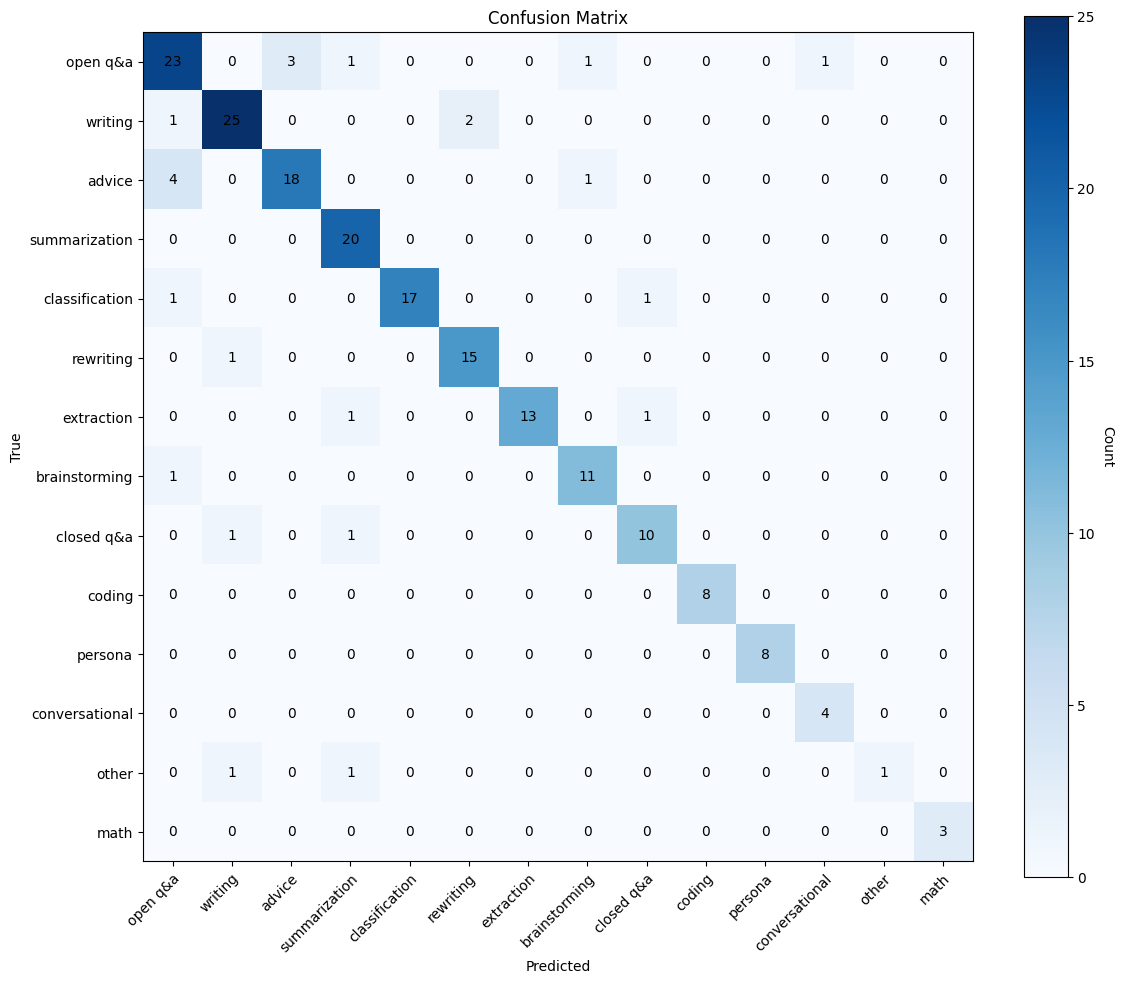

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your confusion matrix data
confusion_matrix = np.array([
    [23,  0,  3,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0],
    [ 1, 25,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 4,  0, 18,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 1,  0,  0,  0, 17,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  1,  0,  0, 13,  0,  1,  0,  0,  0,  0,  0],
    [ 1,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  1,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0],
    [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3]
])

# Create labels
labels = ['open q&a', 'writing', 'advice', 'summarization', 'classification', 'rewriting', 'extraction', 'brainstorming', 'closed q&a', 'coding', 'persona', 'conversational', 'other', 'math']


counts = confusion_matrix.sum(axis=1)
label_ratio = counts / counts.sum()
domain_ratio_preference = dict(zip(labels, label_ratio))
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Create color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")
# Set x-axis labels
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

# Set y-axis labels
ax.set_yticklabels(labels)
# Show the plot
plt.tight_layout()
# plt.show()

In [ ]:

import pandas as pd

data = {
    'Domain': [
        'open q&a', 'writing', 'advice', 'summarization', 'classification', 'rewriting',
        'extraction', 'brainstorming', 'closed q&a', 'coding', 'persona', 'conversational',
        'other', 'math'
    ],
    'Accuracy': [
        0.935, 0.97, 0.96, 0.98, 0.99, 0.985, 0.99, 0.985, 0.98, 1.0, 1.0, 0.995, 0.99, 1.0
    ],
    'Precision': [
        0.865686274509804, 0.9377076411960132, 0.9146049481245011, 0.9166666666666667,
        0.994535519125683, 0.9384442301510768, 0.9946524064171123, 0.9204031262854793,
        0.9113475177304965, 1.0, 1.0, 0.9, 0.9949748743718593, 1.0
    ],
    'Recall': [
        0.8760838878806211, 0.9377076411960132, 0.8828297715549005, 0.9888888888888889,
        0.9473684210526316, 0.9633152173913043, 0.9333333333333333, 0.9530141843971631,
        0.9113475177304965, 1.0, 1.0, 0.9974489795918368, 0.6666666666666666, 1.0
    ],
    'F1 Score': [
        0.8707689248968637, 0.9377076411960132, 0.8978549540347294, 0.9489274770173646,
        0.9694749694749695, 0.9504582610849641, 0.9615975422427036, 0.9359999999999999,
        0.9113475177304965, 1.0, 1.0, 0.9431656720659278, 0.7474747474747474, 1.0
    ],
    'AUC Score': [
        0.8760838878806211, 0.9377076411960132, 0.8828297715549005, 0.9888888888888888,
        0.9473684210526316, 0.9633152173913043, 0.9333333333333333, 0.9530141843971631,
        0.9113475177304966, 1.0, 1.0, 0.9974489795918368, 0.6666666666666666, 1.0
    ]
}

df = pd.DataFrame(data)
df

,Domain,Accuracy,Precision,Recall,F1 Score,AUC Score
0,open q&a,0.935,0.865686,0.876084,0.870769,0.876084
1,writing,0.970,0.937708,0.937708,0.937708,0.937708
2,advice,0.960,0.914605,0.882830,0.897855,0.882830
3,summarization,0.980,0.916667,0.988889,0.948927,0.988889
4,classification,0.990,0.994536,0.947368,0.969475,0.947368
5,rewriting,0.985,0.938444,0.963315,0.950458,0.963315
6,extraction,0.990,0.994652,0.933333,0.961598,0.933333
7,brainstorming,0.985,0.920403,0.953014,0.936000,0.953014
8,closed q&a,0.980,0.911348,0.911348,0.911348,0.911348
9,coding,1.000,1.000000,1.000000,1.000000,1.000000


('open q&a', 'conversational', 'advice', 'writing', 'coding', 'rewriting', 'closed q&a', 'brainstorming', 'extraction', 'summarization', 'math', 'persona', 'classification', 'help with given error', 'other', 'code modification', 'code testing', 'help understand given code')


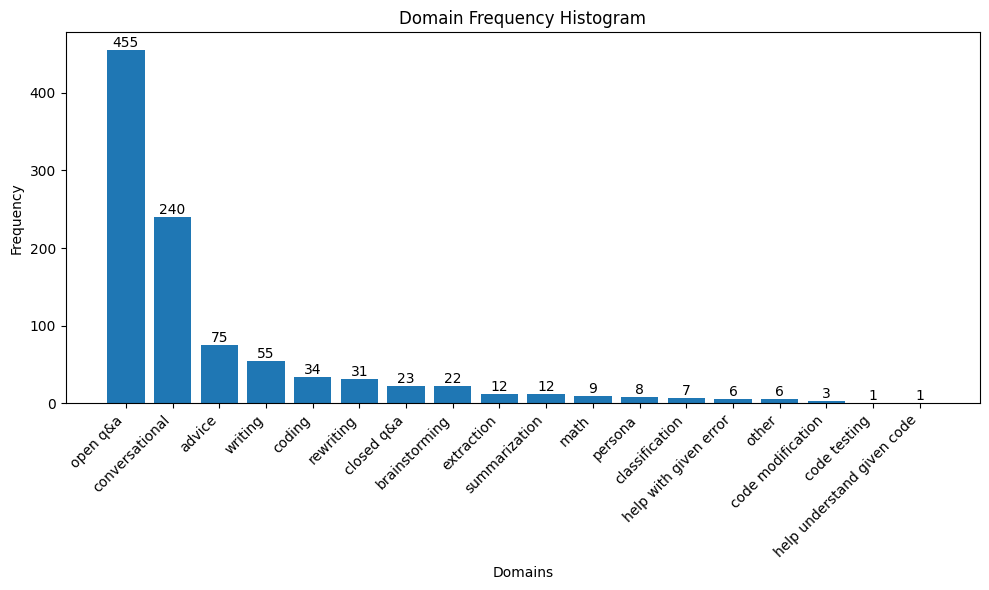

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Example list of domains

# Count the frequency of each domain
domain_counts = Counter(all_domains)

# Sort domains by frequency for better visualization
sorted_domains = sorted(domain_counts.items(), key=lambda x: x[1], reverse=True)
# Extract domains and their counts
domain_names, domain_frequencies = zip(*sorted_domains)
print(domain_names)
# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(domain_names, domain_frequencies)

# Customize the chart
plt.title("Domain Frequency Histogram")
plt.xlabel("Domains")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Reference: check preference/rl data distribution [no need to read]

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_results is your list of dictionaries containing domain information
# Example: all_results = [{"domain": "example.com"}, {"domain": "xai.com"}, ...]

# Extract and count the domains
# all_domains = [x["domain"] for x in all_results]
# domain_counts = Counter(all_domains)

# Calculate total count
# total_count = len(all_domains)

domain_percentages = dict(domain_ratio_preference)

# Sort domains by frequency and calculate percentages
sorted_domains = [k[0] for k in sorted(domain_ratio.items(), key=lambda x: x[1], reverse=True)]
percentages = [domain_percentages[d] * 100 for d in sorted_domains]

# Create the histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(domain_names, percentages)

# Customize the chart
plt.title("Domain Distribution - Preference")
plt.xlabel("Domains")
plt.ylabel("Percentage (%)")
plt.ylim(0, 50)  # Ensure y-axis starts at 0 and ends at 100%

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'domain_ratio' is not defined

# Revisit User Feedback Data

In [ ]:
#@title fetch actual user feedback data
df_feedback = pl.read_parquet("/data/zihang/grok_x_trace/latest/2024-10-10/feedback_only.parquet").to_pandas()
df_feedback

,chatId,userId,sorted_date,sorted_chatItemId,sorted_sender,sorted_queries,sorted_generatedImageUrls,sorted_modelVersion,sorted_message,sorted_feedback,conversation_id,sorted_response_to_chat_item_id,sorted_debug_info
0,1850015271005884557,1634612845018226688,"[1729912989, 1729912989, 1729913015, 172991301...","[1850015273681600512, 1850015282581979136, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[神仏に向かって手を合わせて祈りを捧げる行為をさして、どの様な熟語がありますか？, その行為...","[None, LIKE, None, LIKE, None, LIKE, None, Non...",1.850015e+18,"[1850015273681600512, 1850015387506630656, 185...","[[{'context': {'time': None, 'timezone': None,..."
1,1853519903161983027,1394691581316411400,"[1730748568, 1730748568, 1730748619, 173074861...","[1853519904030208001, 1853519954101891072, 185...","[USER, AGENT, USER, AGENT, USER, AGENT]","[[], [what is the criticism against 343 indust...","[[], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[Why is there so much negativity towards 343 i...,"[None, None, None, DISLIKE, None, DISLIKE]",1.853520e+18,"[1853519904030208001, 1853520120418648064, 185...","[[{'context': {'time': None, 'timezone': None,..."
2,1855182491000222097,115040885,"[1731144965, 1731144965, 1731145818, 1731145818]","[1855182493328031744, 1855182564039794689, 185...","[USER, AGENT, USER, AGENT]","[[], [[[],[]]], [], [[[],[]]]]","[[], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[hi, looking for suggestions on either to writ...","[None, LIKE, None, None]",1.855182e+18,"[1855182493328031744, 1855182795078799360, 185...","[[{'context': {'time': None, 'timezone': None,..."
3,1852536394104606983,1282310614317064193,"[1730514081, 1730514081]","[1852536395249643520, 1852536442729234432]","[USER, AGENT]","[[], [cybercab charging station location]]","[[], []]","[grok-2-latest, grok-2-latest]",[Where can I setup a charging station for a cy...,"[None, LIKE]",1.852536e+18,[1852536395249643520],"[[{'context': {'time': None, 'timezone': None,..."
4,1852797762355777672,1584426763953704962,"[1730576394, 1730576394, 1730576432, 173057643...","[1852797764281016320, 1852797805007667200, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [mash up reel highlights from profile vid...","[[], [], [], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[Can you make a mash up reel of highlights fro...,"[None, None, None, None, None, None, None, LIKE]",1.852798e+18,"[1852797764281016320, 1852797959358013440, 185...","[[{'context': {'time': None, 'timezone': None,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62998,1857634267955867972,260140483,"[1731730707, 1731730707]","[1857639330031824896, 1857639330031824897]","[USER, AGENT]","[[], [[[],[]]]]","[[], []]","[grok-2-latest, grok-2-latest]","[Next, Something went wrong while responding t...","[None, DISLIKE]",1.857634e+18,"[1857634272019947520, 1857634445877997568, 185...","[[{'context': {'time': None, 'timezone': None,..."
62999,1858254411010871736,1488436972792205314,"[1731877370, 1731877370]","[1858254418178658304, 1858254418178658305]","[USER, AGENT]","[[], [[[],[]]]]","[[], []]","[grok-2-latest, grok-2-latest]","[Tell me everything about the Kandahar Giant ,...","[None, LIKE]",NaN,[],[]
63000,1854182309626568720,55680820,"[1730906495, 1730906495]","[1854182310884560911, 1854182348339757058]","[USER, AGENT]","[[], []]","[[], []]","[grok-2-latest, grok-2-latest]","[welcher Körpermasse sollte man kennen, um Kle...","[None, LIKE]",1.854182e+18,[1854182310884560911],"[[{'context': {'time': None, 'timezone': None,..."
63001,1849252319201837475,1605003606364659712,"[1729731137, 1729731137]","[1849252320350986240, 1849252538916204544]","[USER, AGENT]","[[], [regulatory bodies autonomous vehicles NH...","[[], []]","[grok-2-latest, grok-2-latest]",[What are the types of 

In [ ]:
# Function to check if 'DISLIKE' is in the list or if the list is None
def contains_dislike(feedbacks):
    if 'DISLIKE' in feedbacks:  # Check for None or empty list
        return True
    return False
# Apply the function to create a new column
df_feedback_neg = df_feedback[df_feedback['sorted_feedback'].apply(contains_dislike)]
df_feedback_neg

,chatId,userId,sorted_date,sorted_chatItemId,sorted_sender,sorted_queries,sorted_generatedImageUrls,sorted_modelVersion,sorted_message,sorted_feedback,conversation_id,sorted_response_to_chat_item_id,sorted_debug_info
1,1853519903161983027,1394691581316411400,"[1730748568, 1730748568, 1730748619, 173074861...","[1853519904030208001, 1853519954101891072, 185...","[USER, AGENT, USER, AGENT, USER, AGENT]","[[], [what is the criticism against 343 indust...","[[], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[Why is there so much negativity towards 343 i...,"[None, None, None, DISLIKE, None, DISLIKE]",1.853520e+18,"[1853519904030208001, 1853520120418648064, 185...","[[{'context': {'time': None, 'timezone': None,..."
63,1846141817106088017,1789573800193089536,"[1728989498, 1728989498]","[1846141818695831554, 1846141878024261632]","[USER, AGENT]","[[], [Grokからの期待ハズレの具体性がない答え since:2024-10-01]]","[[], []]","[grok-2-latest, grok-2-latest]",[Grokから期待ハズレの具体性がない答えが返ってくると時間の無駄を感じて、どっと疲れがでま...,"[None, DISLIKE]",1.846142e+18,[1846141818695831554],"[[{'context': {'time': None, 'timezone': None,..."
81,1845456767427223847,1726453928336707584,"[1728826171, 1728826171, 1728826225, 172882622...","[1845456820913016841, 1845456836985528333, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [What did I ask you? from:YourUsername s...","[[], [], [], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[What did I ask you?, You asked whether X user...","[None, None, None, None, None, None, None, DIS...",1.845457e+18,"[1845456768199020554, 1845456820913016841, 184...","[[{'context': {'time': None, 'timezone': None,..."
90,1852367611092169161,1486323846995193856,"[1730473842, 1730473842]","[1852367612698591232, 1852367668403179520]","[USER, AGENT]","[[], [Are Covid 19 vaccines safe? since:2024-1...","[[], []]","[grok-2-latest, grok-2-latest]","[Are Covid 19 vaccines safe?, The safety of CO...","[None, DISLIKE]",1.852368e+18,[1852367612698591232],"[[{'context': {'time': None, 'timezone': None,..."
103,1853665679536451656,1473556684270280708,"[1730783322, 1730783322, 1730783367, 173078336...","[1853665681050640384, 1853665724730134528, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [will tesla stock price increase if trump...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[if trump wins, will tesla stock go up, If Don...","[None, None, None, None, None, None, None, Non...",1.853666e+18,"[1853665681050640384, 1853665858507444224, 185...",[[{'context': {'time': '2024-11-05T05:08:32.50...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62962,1851960054833979401,1730112319785463808,"[1730376663, 1730376663, 1730376809, 1730376809]","[1851960056134107136, 1851960069761503232, 185...","[USER, AGENT, USER, AGENT]","[[], [], [], [Reformationstag in Dänemark Feie...","[[], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[Ist der Reformationstag in Dänemark ein Feier...,"[None, DISLIKE, None, None]",1.851960e+18,"[1851960056134107136, 1851960670587158528]","[[{'context': {'time': None, 'timezone': None,..."
62967,1853087339607715867,1817867251351199744,"[1730645426, 1730645426, 1730645443, 173064544...","[1853087340761141248, 1853087344556924928, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[Daj mi neki vic o tumoru, Naravno, evo jednog...","[None, DISLIKE, None, None, None, None, None, ...",1.853087e+18,"[1853087340761141248, 1853087409639952384, 185...","[[{'context': {'time': None, 'timezone': None,..."
62972,1849504535447998647,1509004829464543233,"[1729791256, 1729791256, 1729791312, 172979131...","[1849504536005885952, 1849504698841411584, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], []

In [ ]:
msgs_till_last_dislike = []
msgs_till_last_dislike_no_search = []

for _ , r in df_feedback_neg.iterrows():
  for i, f in enumerate(r['sorted_feedback']):
    if f == 'DISLIKE':
      conv = []
      for j in range(i+1):
        conv.append({"role": r["sorted_sender"][j], "content": r['sorted_message'][j], "feedback": r['sorted_feedback'][j]})
      r["conversation"] = conv
      msgs_till_last_dislike.append(r)
      if len(sum([x.tolist() for x in r['sorted_queries']], [])) == 0:
        msgs_till_last_dislike_no_search.append(r)
      break

In [ ]:
print(len(msgs_till_last_dislike), len(msgs_till_last_dislike_no_search))
msgs_till_last_dislike_df = pd.DataFrame(msgs_till_last_dislike)
msgs_till_last_dislike_no_search_df = pd.DataFrame(msgs_till_last_dislike_no_search)
msgs_till_last_dislike_df = msgs_till_last_dislike_df.sample(frac=1)
msgs_till_last_dislike_no_search_df = msgs_till_last_dislike_no_search_df.sample(frac=1)

# msgs_till_last_dislike_df.to_parquet("/data/yuchen/prod_data/grok_x_trace/thumbdown_since241020.parquet")
# msgs_till_last_dislike_no_search_df.to_parquet("/data/yuchen/prod_data/grok_x_trace/thumbdown_since241020_no_search.parquet")


In [ ]:
# Function to check if 'LIKE' is in the list or if the list is None
def contains_like(feedbacks):
    if 'LIKE' in feedbacks and "DISLIKE" not in feedbacks:  # Check for None or empty list
        return True
    return False
# Apply the function to create a new column
df_feedback_pos = df_feedback[df_feedback['sorted_feedback'].apply(contains_like)]
df_feedback_pos

,chatId,userId,sorted_date,sorted_chatItemId,sorted_sender,sorted_queries,sorted_generatedImageUrls,sorted_modelVersion,sorted_message,sorted_feedback,conversation_id,sorted_response_to_chat_item_id,sorted_debug_info
0,1850015271005884557,1634612845018226688,"[1729912989, 1729912989, 1729913015, 172991301...","[1850015273681600512, 1850015282581979136, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[神仏に向かって手を合わせて祈りを捧げる行為をさして、どの様な熟語がありますか？, その行為...","[None, LIKE, None, LIKE, None, LIKE, None, Non...",1.850015e+18,"[1850015273681600512, 1850015387506630656, 185...","[[{'context': {'time': None, 'timezone': None,..."
2,1855182491000222097,115040885,"[1731144965, 1731144965, 1731145818, 1731145818]","[1855182493328031744, 1855182564039794689, 185...","[USER, AGENT, USER, AGENT]","[[], [[[],[]]], [], [[[],[]]]]","[[], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[hi, looking for suggestions on either to writ...","[None, LIKE, None, None]",1.855182e+18,"[1855182493328031744, 1855182795078799360, 185...","[[{'context': {'time': None, 'timezone': None,..."
3,1852536394104606983,1282310614317064193,"[1730514081, 1730514081]","[1852536395249643520, 1852536442729234432]","[USER, AGENT]","[[], [cybercab charging station location]]","[[], []]","[grok-2-latest, grok-2-latest]",[Where can I setup a charging station for a cy...,"[None, LIKE]",1.852536e+18,[1852536395249643520],"[[{'context': {'time': None, 'timezone': None,..."
4,1852797762355777672,1584426763953704962,"[1730576394, 1730576394, 1730576432, 173057643...","[1852797764281016320, 1852797805007667200, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [mash up reel highlights from profile vid...","[[], [], [], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[Can you make a mash up reel of highlights fro...,"[None, None, None, None, None, None, None, LIKE]",1.852798e+18,"[1852797764281016320, 1852797959358013440, 185...","[[{'context': {'time': None, 'timezone': None,..."
5,1856219257853411344,1823109809849159680,"[1731392144, 1731392144, 1731393035, 1731393035]","[1856219258545405952, 1856219258545405953, 185...","[USER, AGENT, USER, AGENT]","[[], [[[],[]]], [], [[[],[]]]]","[[], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[How little can you invest in a safe bitcoin p...,"[None, LIKE, None, None]",1.856219e+18,"[1856219258545405952, 1856223027744100352]",[[{'context': {'time': '2024-11-12T06:15:32.82...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62996,1856110330180477053,1589683323583877120,"[1731366171, 1731366171]","[1856110331535163392, 1856110368965132288]","[USER, AGENT]","[[], [[[],[]]]]","[[], []]","[grok-2-latest, grok-2-latest]",[Does Elise Stephanik have to leave Congress t...,"[None, LIKE]",1.856110e+18,[1856110331535163392],"[[{'context': {'time': None, 'timezone': None,..."
62999,1858254411010871736,1488436972792205314,"[1731877370, 1731877370]","[1858254418178658304, 1858254418178658305]","[USER, AGENT]","[[], [[[],[]]]]","[[], []]","[grok-2-latest, grok-2-latest]","[Tell me everything about the Kandahar Giant ,...","[None, LIKE]",NaN,[],[]
63000,1854182309626568720,55680820,"[1730906495, 1730906495]","[1854182310884560911, 1854182348339757058]","[USER, AGENT]","[[], []]","[[], []]","[grok-2-latest, grok-2-latest]","[welcher Körpermasse sollte man kennen, um Kle...","[None, LIKE]",1.854182e+18,[1854182310884560911],"[[{'context': {'time': None, 'timezone': None,..."
63001,1849252319201837475,1605003606364659712,"[1729731137, 1729731137]","[1849252320350986240, 1849252538916204544]","[USER, AGENT]","[[], [regulatory bodies autonomous vehicles NH...","[[], []]","[grok-2-latest, grok-2-latest]",[What are the types of federal and state regul...,"[None, LIKE]",1.849252e+18,[1849252320350986240],"[[{'context': {

In [ ]:
msgs_till_last_like = []
msgs_till_last_like_no_search = []
msgs_till_last_like_search = []

for _ , r in df_feedback_pos.iterrows():
  for i, f in enumerate(r['sorted_feedback']):
    if f == 'LIKE':
      conv = []
      for j in range(i+1):
        conv.append({"role": r["sorted_sender"][j], "content": r['sorted_message'][j], "feedback": r['sorted_feedback'][j]})
      r["conversation"] = conv
      msgs_till_last_like.append(r)
      if len(sum([x.tolist() for x in r['sorted_queries']], [])) == 0:
        msgs_till_last_like_no_search.append(r)
      else:
        msgs_till_last_like_search.append(r)
      break


In [ ]:
print(len(msgs_till_last_like), len(msgs_till_last_like_no_search))
# msgs_till_last_like_df = pd.DataFrame(msgs_till_last_like)
# msgs_till_last_like_df = msgs_till_last_like_df.sample(frac=1)

# msgs_till_last_like_no_search_df = pd.DataFrame(msgs_till_last_like_no_search)
# msgs_till_last_like_no_search_df = msgs_till_last_like_no_search_df.sample(frac=1, random_state=42)


msgs_till_last_like_search_df = pd.DataFrame(msgs_till_last_like_search)
msgs_till_last_like_search_df = msgs_till_last_like_search_df.sample(frac=1, random_state=42)

# msgs_till_last_like_df.to_parquet("/data/yuchen/prod_data/grok_x_trace/thumbup_since241020.parquet")
# msgs_till_last_like_no_search_df.to_parquet("/data/yuchen/prod_data/grok_x_trace/thumbup_since241020_no_search.parquet")


57630 19451


In [ ]:
msgs_till_last_dislike_df = utils.read_df(glob.glob("/data/yuchen/prod_data/grok_x_trace/thumbdown_since241020.parquet"))
msgs_till_last_dislike_no_search_df = utils.read_df(glob.glob("/data/yuchen/prod_data/grok_x_trace/thumbdown_since241020_no_search.parquet"))
# msgs_till_last_like_df = utils.read_df("/data/yuchen/prod_data/grok_x_trace/thumbup_since241020.parquet")
# msgs_till_last_like_no_search_df = utils.read_df(glob.glob("/data/yuchen/prod_data/grok_x_trace/thumbup_since241020_no_search.parquet"))
included_new=[4, 5, 6, 7, 9]
excluded_new=[0, 1, 2, 3, 8]


reading paths: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


In [ ]:
df = msgs_till_last_dislike_no_search_df
target = 50
for idx, r in df.iterrows():
  if idx in included_new or idx in excluded_new:
    continue
  display_conversation(r["conversation"])
  print("idx=", idx, "len=", len(included_new))
  print(f"included_new={included_new} \nexcluded_new={excluded_new}" )
  user_input = input(f"Please enter your choice: \n").strip().lower()
  if user_input == 'n':
    excluded_new.append(idx)
  elif user_input == 'q':
    break
  else:
    included_new.append(idx)
  if len(included_new) == target:
    print(f"{target}!!!")
    break
  clear_output()

idx= 66 len= 49
included_new=[4, 5, 6, 7, 9, 11, 12, 14, 15, 16, 17, 19, 20, 21, 23, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65] 
excluded_new=[0, 1, 2, 3, 8, 10, 13, 18, 22, 24, 26, 31, 43, 46, 47, 55, 61]
Please enter your choice: 

50!!!


In [ ]:
info_selected = []
for idx, r in df.iterrows():
  if idx not in included_new:
    continue
  else:
    info_selected.append(r)
print(len(info_selected))
info_selected_df = pd.DataFrame(info_selected)
info_selected_df.to_parquet("/data/yuchen/prod_data/thumbdown_since241020_50wq.parquet")


50


In [ ]:
msgs_rating[1]['sorted_debug_info']

array([array([{'context': {'time': None, 'timezone': None, 'language': None}, 'options': {'response_sampling': {'max_len': None, 'rng_seed': None, 'temperature': None, 'nucleus_p': None, 'stop_strings': array([], dtype=object)}, 'decider': {'img_gen': None, 'web_search': None, 'x_search': None, 'decision_llm': {'max_len': None, 'rng_seed': None, 'temperature': None, 'nucleus_p': None, 'stop_strings': array([], dtype=object)}, 'querygen_llm': {'max_len': None, 'rng_seed': None, 'temperature': None, 'nucleus_p': None, 'stop_strings': array([], dtype=object)}}, 'tools': {'img_gen': {'width': None, 'height': None, 'steps': None, 'polling_interval': None, 'timeout': None}, 'web_search': {'num_results': None, 'backend': None}, 'x_search': {'min_score_threshold': None, 'num_results_first_pass': None, 'num_results': None, 'rejector_on': None, 'p_bad_max': None}}, 'personality': {'personality': None, 'add_acknowledgment_question': None}, 'conversation': {'max_ntokens': None, 'reserve_ntokens': 

# Find bad user response for multiturn data

In [9]:
#@title a. find data with regex
import random

def filter_dissatisfaction(df):
    potential_user_dislike_responses = []
    potential_model_approligize_reponses = []
    multiturn = 0
    potential_ok_requests = []
    # r_user_bad = r"(?i)(^|\s)(that'?s?\snot\s(what\si\smean|correct|true|what\si\sasked)|no|(this|that|you)\sis\s(stupid|wrong|terrible)|i\sdont?\slike\si?t|not\s(helpful|what\si\sasked)|you'?re?\s(incorrect|wrong)|disagree|i\s(hate )?this)(\s|$)"
    # r_user_bad = r"(?i)(^|\s)(that'?s?\snot\s(what\si\smean|correct|true|what\si\sasked)|no|(this|that|you)\sis\s(stupid|wrong|terrible|pointless|useless|frustrating|annoying|bad|not\s(helpful|useful|what\si\sasked))|i\sdont?\slike\si?t|you'?re?\s(incorrect|wrong|slow)|disagree|i\s(hate )?this|what'?s?\swrong\s?with\syou|are\syou\skidding\s?me|you'?ve\s?got\sto\s?be\s?joking|seriously|useless|waste\sof\stime|expected\smore|isn'?t?\sworking|completely\soff|try\sagain|do\sit\sover|can\syou\sfix\sthis|need\sto\sget\sit\sright|please\scorrect\s?that|argh|grr|damn\s?it?|oh\scome\son|hurry\sup|this\sis\staking\sforever)(\s|$)"
    r_user_bad = r"\b(?:bad|wrong|fail(?:ed)?|incomplete|missing|inefficient|reject(?:ed)?|incorrect|unnecessary|defective|lacking|frustrat(?:ed|ion)|inaccurate|try\s+again|do\s+better|improve|redo(?: this| all errors)?|make it better|more creative|more personable|better\s+way|reformule\s+mieux|not|no|insufficient|void|null|empty|nothing|inactive|can'?t|unable\s+to|not\s+possible|refus(?:e|al))\b"
    r_model_appoligize = r"(?i)(^|\s)(apologies\sfor|sorry\s(about|for)|i'?m?\ssorry|my\sapologies|pardon\sme\sfor|excuse\sme\sfor|i\sapologize|forgive\sme\sfor|so\ssorry\sabout)(\s|$)"
    for _, row in df.iterrows():
        if len(row["message"]) > 2:
          multiturn += 1
        else:
          continue
        if re.match(r_user_bad, row["message"][-2]):
          row["org_conversation"] = row["conversation"]
          row["conversation"] = row["conversation"][:-2]
          row["reward"] = 0
          row["implicit_feedback"] = "user_dislike"
          potential_user_dislike_responses.append(row)
          continue
        if re.match(r_model_appoligize, row["message"][-1]):
          row["org_conversation"] = row["conversation"]
          row["conversation"] = row["conversation"][:-2]
          row["reward"] = 0
          row["implicit_feedback"] = "model_applogize"
          potential_model_approligize_reponses.append(row)
          continue
        # if random.random() < 0.05:
        #   row["reward"] = 1.0
        #   row["org_conversation"] = row["conversation"]
        #   row[""]
        #   potential_ok_requests += [row]
    print(multiturn, len(potential_user_dislike_responses), len(potential_model_approligize_reponses))
    potential_user_dislike_responses_df = pd.DataFrame(potential_user_dislike_responses)
    potential_model_approligize_reponses_df = pd.DataFrame(potential_model_approligize_reponses)
    return potential_user_dislike_responses_df, potential_model_approligize_reponses_df

root = "/data/zihang/grok_x_trace/"
output = "/data/yuchen/prod_data/grok_x_trace/"
subfiles = os.listdir(root)
subfiles = sorted(subfiles, reverse=True)
print(subfiles)
for file in subfiles:
  path = root + "/" + file
  # print(file)
  input_path = path + "/normal.parquet"
  if not os.path.exists(input_path):
    continue
  if "2024" not in file:
    continue
  output_path = output + "/" + file
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  # else:
  #   continue
  df = pl.read_parquet(input_path).to_pandas()
  potential_user_dislike_responses_df, potential_model_approligize_reponses_df = filter_dissatisfaction(df)

  potential_user_dislike_responses_df.to_parquet(output_path + "/user_dislike_v1.parquet")
  # potential_model_approligize_reponses_df.to_parquet(output_path + "/model_applogize.parquet")

print("done", len(potential_user_dislike_responses_df))
all_user_dislike_since1020_df = utils.read_df(glob.glob(output + "/2024-1*/*user_dislike_v1.parquet"))
# all_model_applogize_since1020_df = utils.read_df(glob.glob(output + "/2024-1*/*model_applogize.parquet"))

all_user_dislike_since1020_df.to_parquet(output + "/user_dislike_since2410_v1.parquet")
# all_model_applogize_since1020_df.to_parquet(output + "/model_applogize_since2410.parquet")
print()
print(len(all_user_dislike_since1020_df), len(all_model_applogize_since1020_df))


['users_0814', 'latest', 'clustering', '2024-11-05', '2024-11-04', '2024-11-03', '2024-11-02', '2024-11-01', '2024-10-31', '2024-10-30', '2024-10-29', '2024-10-28', '2024-10-27', '2024-10-26', '2024-10-25', '2024-10-24', '2024-10-23', '2024-10-22', '2024-10-21', '2024-10-20', '2024-10-19', '2024-10-18', '2024-10-17', '2024-10-16', '2024-10-15', '2024-10-14', '2024-10-13', '2024-10-12', '2024-10-11', '2024-10-10', '2024-10-09', '2024-10-08', '2024-10-07', '2024-10-06', '2024-10-05', '2024-10-04', '2024-10-03', '2024-10-02', '2024-10-01', '2024-09-30', '2024-09-29', '2024-09-28', '2024-09-27', '2024-09-26', '2024-09-25', '2024-09-24', '2024-09-23', '2024-09-22', '2024-09-21', '2024-09-20', '2024-09-19', '2024-09-18', '2024-09-17', '2024-09-16', '2024-09-15', '2024-09-14', '2024-09-13', '2024-09-12', '2024-09-11', '2024-09-10', '2024-09-09', '2024-09-08', '2024-09-07', '2024-09-06', '2024-09-05', '2024-09-04', '2024-09-03', '2024-09-02', '2024-09-01', '2024-08-31', '2024-08-30', '2024-08-

reading paths: 100%|████████████████████████████████████| 36/36 [00:00<00:00, 51.86it/s]


NameError: name 'all_model_applogize_since1020_df' is not defined

7579


In [ ]:
output = "/data/yuchen/prod_data/grok_x_trace/"
all_user_dislike_since1020_df = utils.read_df(output + "/user_dislike_since2410.parquet")
all_model_applogize_since1020_df = utils.read_df(output + "/model_applogize_since2410.parquet")

def is_query_of_none(entry):
    entry = entry.tolist()
    if isinstance(entry, list):
        return all(el is None for el in entry)
    return False
# Filter rows where `queries` is NOT a list of None
df = all_user_dislike_since1020_df #  pd.concat([all_user_dislike_since1020_df, all_model_applogize_since1020_df])
filtered_df = df[df['queries'].apply(is_query_of_none)]

reading paths: 100%|██████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


In [ ]:
sample_df = filtered_df.sample(n=1000, random_state=42)

In [ ]:
included=[7056, 1111, 1208, 1914, 1253, 5280, 2095, 2848, 449, 4528, 6623, 5861, 390, 3460, 7330, 6571, 177, 632, 4585, 4924, 5295, 485, 6176, 2943, 5752, 2194, 798, 5127, 8243, 2299, 4394, 4089, 6154, 3552, 2594, 372, 7215, 7085, 4867, 503, 2073, 2677, 5707, 7297, 6536, 3410, 3284, 4194, 7065, 3512, 740, 185, 1690, 4434, 4514, 7886, 3165, 2362, 3302]
excluded=[746, 5208, 5091, 6896, 6419, 1379, 3984, 2635, 2443, 7615, 4466, 602, 6266, 3248, 766, 5490, 3987, 80, 123, 7818, 6729, 2081, 5570, 4803, 1001, 476, 7893, 7785, 3441, 7904, 673, 7287, 6185, 2792, 7515, 2458, 2033, 4613, 1535, 7101, 1699, 767, 1515, 3053, 5283, 1784, 3872, 124, 7790, 4704, 4654, 3402, 4742, 756, 2662, 6451, 2001, 44, 4801, 4290, 1971, 2818, 1450, 4970, 6142, 2546, 7604, 5911, 2052, 6941, 62, 7437, 631, 810, 1065, 5782, 1227, 7700, 811, 7851, 5600, 72, 536, 2927, 354, 7513, 6423, 5353, 1799, 6343, 3509, 2476, 5781, 7779, 6296, 4575, 1156, 2099, 5562, 6681, 6883, 2538, 4272, 4523, 8172, 1397, 1414, 3615, 4247, 3370, 1125, 4286, 3343, 7539, 797, 6324, 3579, 1990, 5853, 5082, 6446, 3623, 1143, 5428, 6127, 8291, 6823, 2853, 3540, 7151, 195, 7420, 8019, 227, 6897, 7453, 4096, 3720, 5920, 2042, 7969, 4758, 7352, 915, 506, 3740, 4078, 5500, 3195, 1817, 8137, 2632, 8076, 443, 3173, 7036, 5137, 5864, 4219, 2846, 1029, 4416, 4348, 3708, 4055, 6388, 2522, 3954, 460, 1323, 6510, 790, 4773, 7993, 3917, 512, 4176, 250, 5948, 4025, 7383, 2040, 1432, 2373, 1639, 1769, 1130, 5365, 4407, 110, 3403, 7888, 1129, 4104, 7947, 6254, 6014, 6666, 3636, 8269, 1264, 2426, 7734, 2117, 2508, 5029, 720, 3672, 4160, 1886, 7867, 635, 1812, 7259, 2791, 4901, 4996, 8024, 4109, 7641]


In [ ]:

for idx, r in sample_df.iterrows():
  if idx in excluded or idx in included:
    continue
  display_conversation(r["org_conversation"])
  print("idx=", idx, "len=", len(included))
  print(f"included={included} \nexcluded={excluded}" )
  user_input = input(f"Please enter your choice: \n").strip().lower()
  if user_input == 'n':
    excluded.append(idx)
  elif user_input == 'q':
    break
  else:
    included.append(idx)
  if len(included) == 100:
    print("100!!!")
    break
  clear_output()

idx= 1108 len= 99
included=[7056, 1111, 1208, 1914, 1253, 5280, 2095, 2848, 449, 4528, 6623, 5861, 390, 3460, 7330, 6571, 177, 632, 4585, 4924, 5295, 485, 6176, 2943, 5752, 2194, 798, 5127, 8243, 2299, 4394, 4089, 6154, 3552, 2594, 372, 7215, 7085, 4867, 503, 2073, 2677, 5707, 7297, 6536, 3410, 3284, 4194, 7065, 3512, 740, 185, 1690, 4434, 4514, 7886, 3165, 2362, 3302, 7581, 4467, 2803, 4028, 1280, 3462, 4041, 5272, 5748, 2147, 3517, 854, 8209, 7095, 5006, 5408, 7883, 988, 3991, 7992, 1365, 8095, 7744, 4256, 7786, 3651, 8177, 1410, 659, 3125, 6131, 2577, 1093, 890, 5909, 1644, 3408, 3778, 5387, 6301] 
excluded=[746, 5208, 5091, 6896, 6419, 1379, 3984, 2635, 2443, 7615, 4466, 602, 6266, 3248, 766, 5490, 3987, 80, 123, 7818, 6729, 2081, 5570, 4803, 1001, 476, 7893, 7785, 3441, 7904, 673, 7287, 6185, 2792, 7515, 2458, 2033, 4613, 1535, 7101, 1699, 767, 1515, 3053, 5283, 1784, 3872, 124, 7790, 4704, 4654, 3402, 4742, 756, 2662, 6451, 2001, 44, 4801, 4290, 1971, 2818, 1450, 4970, 6142, 2546

In [ ]:
print(len(included), included)
print(len(excluded), excluded)

100 [7056, 1111, 1208, 1914, 1253, 5280, 2095, 2848, 449, 4528, 6623, 5861, 390, 3460, 7330, 6571, 177, 632, 4585, 4924, 5295, 485, 6176, 2943, 5752, 2194, 798, 5127, 8243, 2299, 4394, 4089, 6154, 3552, 2594, 372, 7215, 7085, 4867, 503, 2073, 2677, 5707, 7297, 6536, 3410, 3284, 4194, 7065, 3512, 740, 185, 1690, 4434, 4514, 7886, 3165, 2362, 3302, 7581, 4467, 2803, 4028, 1280, 3462, 4041, 5272, 5748, 2147, 3517, 854, 8209, 7095, 5006, 5408, 7883, 988, 3991, 7992, 1365, 8095, 7744, 4256, 7786, 3651, 8177, 1410, 659, 3125, 6131, 2577, 1093, 890, 5909, 1644, 3408, 3778, 5387, 6301, 1108]
377 [746, 5208, 5091, 6896, 6419, 1379, 3984, 2635, 2443, 7615, 4466, 602, 6266, 3248, 766, 5490, 3987, 80, 123, 7818, 6729, 2081, 5570, 4803, 1001, 476, 7893, 7785, 3441, 7904, 673, 7287, 6185, 2792, 7515, 2458, 2033, 4613, 1535, 7101, 1699, 767, 1515, 3053, 5283, 1784, 3872, 124, 7790, 4704, 4654, 3402, 4742, 756, 2662, 6451, 2001, 44, 4801, 4290, 1971, 2818, 1450, 4970, 6142, 2546, 7604, 5911, 2052, 694

In [ ]:
included_set = []
for idx, r in sample_df.iterrows():
  if idx in included:
    included_set.append(r)
included_df = pd.DataFrame(included_set)
included_df.to_parquet(output + "/user_dislike_since2410_selected100.parquet")

In [ ]:
# model_address = "api-700-sglang.zhu.svc.max.x.ai"
# sampling_args = {"temperature": 0, "top_p": 1.0}
# sampling_client = SamplingClient()
# sampling_client._grok_client.register_model(
#     model=model_address, model_address=model_address, max_parallel=1
# )
# await sampling_client.generate(messages=r["org_conversation"][:-1], model=model_address)

# Post-Processing by Category + Other Filter

In [21]:
#@title classifier
from xlm.posttrain.classifier.chat_category import ChatCategory
from xlm.sampling_client import SamplingClient

client = SamplingClient()
client._grok_client.register_model(model="grok", model_address="v5l-orl-plan17.zihang.svc.fer.x.ai")


classifier = ChatCategory(name="chat_category")
classifier.initialize(client)


# all_user_dislike_since1020_df = utils.read_df(glob.glob(output + "/2024-1*/*user_dislike_v1.parquet"))
# all_user_dislike_since1020_df


# example = {"conversation": []}
# queries = [
#     "Today's news",
#     "How did Joe Biden do in recent trump debate",
#     "What is wrong with elon musk",
# ]
# for query in queries:
#     example["conversation"].append({"role": "user", "content": query})
#     example["conversation"].append({"role": "assistant", "content": "whatever"})
# example = await classifier.process_one_example(example, sampling_kwargs={"model": "grok"})
# print(example)

for idx, r in all_user_dislike_since1020_df.iterrows():
  output = classifier.process_one_example(example=r,  sampling_kwargs={"model": "grok"})
  break


ModuleNotFoundError: No module named 'xlm.posttrain.classifier'

In [20]:
#@title get all eval set excluded
base = "/data/yuchen/prod_data/"
data_eval = [
    utils.load_df(base+ "user_dislike_since2410_selected100.parquet"),
    utils.load_df(base+ "thumbup_since241020_50wq.parquet"),
    utils.load_df(base+ "thumbup_since241020_50nq.parquet"),
    utils.load_df(base+ "thumbdown_since241020_50wq.parquet"),
]
data_eval = pd.concat(data_eval)
data_eval_chatid = data_eval['chatId'].unique()
print(len(data_eval_chatid))


NameError: name 'classifier' is not defined

In [5]:
output_path = "/data/yuchen/prod_data/grok_x_trace/"

# all_user_dislike_since1020_df['id'] = all_user_dislike_since1020_df['chatId']
# all_user_dislike_since1020_df.to_parquet(output_path + "/user_dislike_v1.parquet")

NameError: name 'all_user_dislike_since1020_df' is not defined

In [27]:
# print(output_path + "/user_dislike_v1.parquet")

# cd $XAI_ROOT/train/xlm/posttrain/classifiers
# python run_classifier.py \
#     --input_path "/data/yuchen/prod_data/grok_x_trace/user_dislike_v1.parquet" \
#     --output_path "/data/yuchen/prod_data/grok_x_trace/user_dislike_v1_w_domain.parquet" \
#     --names "chat_category" \
#     --max_size 10

SyntaxError: invalid syntax (566848296.py, line 3)

In [6]:
all_user_dislike_since1020_w_domain_df = utils.read_df(output_path + "/user_dislike_v1_w_domain.parquet")

reading paths: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


In [18]:
# all_user_dislike_since1020_w_domain_df["chat_category/label"]
filtered_df_writing = all_user_dislike_since1020_w_domain_df[
    all_user_dislike_since1020_w_domain_df['chat_category/label'].apply(
        lambda x: any('writing' in s.lower() for s in x) if x is not None else False
    )
]
filtered_df_writing
# filtered_df_writing.to_parquet(output_path + "/user_dislike_v1_w_domain_writing.parquet")

,chatId,userId,message,sender,queries,chatItemId,modelVersion,generatedImageUrls,createdAtDate,conversation,org_conversation,reward,implicit_feedback,id,chat_category/reasoning,chat_category/label
0,1842249817613103481,"[276647290, 276647290, 276647290, 276647290, 2...",[improve this shitpost: Evil has prevailed onc...,"[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, [improve this shitpost: Evil has prevai...","[1842249819093385217, 1842249845634904064, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None, None, None, None, Non...","[2024-10-04T17:06:05.203, 2024-10-04T17:06:05....",[{'content': 'improve this shitpost: Evil has ...,[{'content': 'improve this shitpost: Evil has ...,0,user_dislike,1842249817613103481,[Let's break down the user query step by step ...,"[rewriting, rewriting, knowledge/information-s..."
1,1842205445051605053,"[1327222341307392000, 1327222341307392000, 132...",[make atitle and description with emojis for p...,"[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, [title and description with emojis for ...","[1842205446079160320, 1842205471815409664, 184...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None, None, None]","[2024-10-04T14:09:45.661, 2024-10-04T14:09:45....",[{'content': 'make atitle and description with...,[{'content': 'make atitle and description with...,0,user_dislike,1842205445051605053,[Let's break down the user query step by step:...,"[writing, rewriting, writing]"
2,1842263581989220673,"[1904920914, 1904920914, 1904920914, 1904920914]",[revise using clinical language: Therapist was...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1842263583578611712, 1842263645683646465, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None]","[2024-10-04T18:00:55.391, 2024-10-04T18:00:55....",[{'content': 'revise using clinical language: ...,[{'content': 'revise using clinical language: ...,0,user_dislike,1842263581989220673,[Let's break down the user query step by step ...,[rewriting]
4,1842063086678642773,"[1387757869932728324, 1387757869932728324, 138...","[bohemian rhapsody rewritten to be about ""noth...","[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1842063089098690560, 1842063201296322560, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None]","[2024-10-04T04:44:25.724, 2024-10-04T04:44:25....",[{'content': 'bohemian rhapsody rewritten to b...,[{'content': 'bohemian rhapsody rewritten to b...,0,user_dislike,1842063086678642773,[Let's break down the user query step by step:...,[rewriting]
7,1841991936678498494,"[956996569, 956996569, 956996569, 956996569, 9...","[fix grammar: Hi Carol, \n\nCan you forward th...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, None, None, None, None, None, None, None]","[1841991940776357888, 1841991946967121922, 184...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None, None, None]","[2024-10-04T00:01:17.369, 2024-10-04T00:01:17....","[{'content': 'fix grammar: Hi Carol, Can you...","[{'content': 'fix grammar: Hi Carol, Can you...",0,user_dislike,1841991936678498494,[Let's break down the user query step by step ...,"[rewriting, rewriting, rewriting]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7567,1844531566543826963,"[276647290, 276647290, 276647290, 276647290]",[improve grammar and flow: This will be great ...,"[USER, AGENT, USER, AGENT]","[None, [improve grammar and flow: This will be...","[1844531568091561989, 1844531583509753862, 184...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-10-11T00:12:53.908, 2024-10-11T00:12:53....",[{'content': 'improve grammar and flow: This w...,[{'content': 'improve grammar and flow: This w...,0,user_dislike,1844531566543826963,[Let's break down the user query step by step ...,[rewriting]
7568,1844810670241444316,"[1518734162097688576, 

In [8]:
included = []
excluded = []
for idx, r in filtered_df_writing.iterrows():
  display_conversation(r["org_conversation"])
  user_input = input(f"Please enter your choice: \n").strip().lower()
  if user_input == 'n':
    excluded.append(idx)
  elif user_input == 'q':
    break
  else:
    included.append(idx)
  clear_output()

KeyboardInterrupt: Interrupted by user

In [20]:
def is_query_of_none(entry):
    entry = entry.tolist()
    if isinstance(entry, list):
        return all(el is None for el in entry)
    return False
# Filter rows where `queries` is NOT a list of None
df = all_user_dislike_since1020_w_domain_df #  pd.concat([all_user_dislike_since1020_df, all_model_applogize_since1020_df])
filtered_df_w_query = df[df['queries'].apply(is_query_of_none)]

filtered_df_w_query = filtered_df_w_query[
    filtered_df_w_query['chat_category/label'].apply(
        lambda x: any('info' in s.lower() for s in x) and not any('writing' in s.lower() for s in x) if x is not None else False
    )
]
filtered_df_w_query
# filtered_df_w_query.to_parquet(output_path + "/user_dislike_v1_w_domain_infoseek.parquet")

,chatId,userId,message,sender,queries,chatItemId,modelVersion,generatedImageUrls,createdAtDate,conversation,org_conversation,reward,implicit_feedback,id,chat_category/reasoning,chat_category/label
30,1842132711374278845,"[576281238, 576281238, 576281238, 576281238, 5...",[string in question: Commonly used buttons for...,"[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, None, None, None, None, None, None, None]","[1842132894749282304, 1842132912138764288, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None, None, None, None, None]","[2024-10-04T09:21:26.087, 2024-10-04T09:21:26....",[{'content': 'string in question: Commonly use...,[{'content': 'string in question: Commonly use...,0,user_dislike,1842132711374278845,[Let's break down the user query step by step ...,"[knowledge/information-seeking, knowledge/info..."
39,1841969577980289465,"[1827724240826642433, 1827724240826642433, 182...","[when was operation barborosa, Operation Barba...","[USER, AGENT, USER, AGENT, USER, AGENT]","[None, None, None, None, None, None]","[1842053886003105792, 1842053901530415104, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None, None, None]","[2024-10-04T04:07:28.487, 2024-10-04T04:07:28....","[{'content': 'when was operation barborosa', '...","[{'content': 'when was operation barborosa', '...",0,user_dislike,1841969577980289465,[Let's break down the analysis step by step:\n...,"[knowledge/information-seeking, instruction-fo..."
50,1842183829756518890,"[9212492, 9212492, 9212492, 9212492]",[can you do over the top chili with ground tur...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1842183832331603968, 1842184006231560192, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None]","[2024-10-04T12:44:27.869, 2024-10-04T12:44:27....",[{'content': 'can you do over the top chili wi...,[{'content': 'can you do over the top chili wi...,0,user_dislike,1842183829756518890,[Let's break down the user query step by step ...,[knowledge/information-seeking]
56,1842010725054922898,"[1343348782923194368, 1343348782923194368, 134...","[what is su zhu's x handle, Su Zhu's handle on...","[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1842010726271008768, 1842010732889571328, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None]","[2024-10-04T01:15:56.281, 2024-10-04T01:15:56....","[{'content': 'what is su zhu's x handle', 'rol...","[{'content': 'what is su zhu's x handle', 'rol...",0,user_dislike,1842010725054922898,[Let's break down the analysis step by step:\n...,[knowledge/information-seeking]
176,1842350668205666598,"[848016595158941696, 848016595158941696, 84801...","[in tye movie where there is baymax, ehat was ...","[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1842350670365769728, 1842350682529226753, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None]","[2024-10-04T23:46:46.592, 2024-10-04T23:46:46....",[{'content': 'in tye movie where there is baym...,[{'content': 'in tye movie where there is baym...,0,user_dislike,1842350668205666598,[Let's break down the user query step by step:...,[knowledge/information-seeking]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7537,1844840287153393686,"[39749387, 39749387, 39749387, 39749387]",[i want to remember a one season animated seri...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1844840289766182924, 1844840345034457090, 184...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None]","[2024-10-11T20:39:48.388, 2024-10-11T20:39:48....",[{'content': 'i want to remember a one season ...,[{'content': 'i want to remember a one season ...,0,user_dislike,1844840287153393686,[Let's break down the user query step by step ...,[knowledge/information-seeking]
7540,1844880473954324846,"[52784978, 52784978, 52784978, 52784978]","[what is Apex in programming language

In [ ]:
included = []
excluded = []
for idx, r in filtered_df_w_query.iterrows():
  display_conversation(r["org_conversation"])
  user_input = input(f"Please enter your choice: \n").strip().lower()

  if user_input == 'n':
    excluded.append(idx)
  elif user_input == 'q':
    break
  else:
    included.append(idx)
  clear_output()